## Cryptojacking Detection

Mining cryptocurrencies such as Ethereum and Bitcoin involves completing a proof-of-work where miners solve complex puzzles to earn profit in terms of the cryptocurrency they mined.

Owing to the complexity of the puzzles, mining cryptocurrency often comes with a high computational cost. Developers of large cryptocurrency mining operations have created workarounds that make use of collective resources from users to complete the calculation needed for a proof-of-work.

Cryptojacking is a type of cyberattack that uses malicious scripts similar to those from large cryptocurrency houses to illegally mine cryptocurrency on other people’s machines without their users being aware. These attacks are stealthy and difficult to detect or analyse, often leading to decreased computing speeds for users, as well as crashes due to the strain on computational resources.

The objective of this challenge is to classify network activity from various websites as either cryptojacking or not, based on features related to both network-based and host-based data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.display import display
pd.set_option("max_colwidth", None)
pd.set_option("max_columns", 500)
pd.set_option("max_rows", 500)


from scipy.stats import chi2_contingency, kruskal, ks_2samp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_recall_curve  

import catboost as catt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

#histogram boosting gradient classifer
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier

from imblearn.over_sampling import SMOTE


le = LabelEncoder()



from tqdm import tqdm, tqdm_notebook

import re
warnings.filterwarnings('ignore')
seed = 21
path = '/kaggle/input/cryptojacking/'

/opt/conda/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


### load datasets

In [2]:
train = pd.read_csv(path + 'Train.csv')
test = pd.read_csv(path + 'Test.csv')

In [3]:
train.head()

,ID,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Disc Writing/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Pages Input/sec,Page Errors/sec,Confirmed byte radius,Label
0,ID_4W8AP96UO6,114.798900,3790.450939,28.0,0.427078,6.162365,21.220403,58.492773,63.959387,0.621206,0.521813,24.624612,0.0,1001.533430,27.190843,1
1,ID_UD3TM0ZYND,14.154240,5182.451722,28.0,0.138876,5.399498,0.000000,22.886762,29.508369,0.422183,0.444403,0.044440,0.0,1089.121009,30.150941,0
2,ID_XAG1HC0HWM,0.044444,120.821253,28.0,0.000000,1.577765,0.000000,11.733239,12.888786,0.177776,0.155554,0.044444,0.0,322.464081,28.163287,0
3,ID_CEXD05IR09,31.369916,127228.251100,31.0,0.523750,15.981107,5.356671,602.125436,6976.986795,3.311801,5.756755,5.623394,0.0,12015.169690,34.204404,0
4,ID_X6E97FT8IF,5.046181,1091.620117,25.0,0.069468,1.356022,0.000000,16.138887,13.271234,0.155609,0.133379,0.000000,0.0,550.989619,31.466889,1


In [4]:
train.shape

(8908, 16)

### finding number of missing values, categorical values and numerical values

In [5]:
def Common_data_analysis(data):
    print("{:=^100}".format(" Common data analysis "))
    # default settings.
    column = data.columns
    total_samples = data.shape[0]
    value_dict = {}
    
    # calculate values.
    missing_values = data.isnull().sum().values
    missing_value_percentage = [round((col_missing_count / total_samples) * 100, 2) for col_missing_count in missing_values ]
    datatype = [data.iloc[:,i].dtype for i in range(data.shape[1])]
    
    categorical_data = list(data.loc[:,data.dtypes == 'object'].columns)
    numerical_data = [d for d  in column if d not in categorical_data]
    # print the diff datatype and count.
    print()
    print("Numerical data list {} ---> total {} numerical values".format(numerical_data, len(numerical_data)))
    print("Categorical data list {} ---> total {} categorical values".format(categorical_data, len(categorical_data)))
    print()
    
    # organise values.
    value_dict["data type"] = datatype
    value_dict["Missing Value"] = missing_values
    value_dict["% of Missing value"] = missing_value_percentage
    df = pd.DataFrame(value_dict, columns = value_dict.keys(), index = column)
    
    # make a highlight for col has high missing value percentage. (>55% say)
    # the particular row will be highlighted if it above missing value threshold.
    def highlight_high_missing_value(sample):
        threshold = 10.0
        style = sample.copy()
        highlight = 'background-color: red;'
        if sample[2] > threshold:
            style[:] = highlight
        else:
            style[:] = ''
        return style
    df = df.style.apply(highlight_high_missing_value, axis = 1)
    display(df)
    return (column, categorical_data, numerical_data)

data_columns, categorical_data, numerical_data = Common_data_analysis(train)


======================================= Common data analysis =======================================

Numerical data list ['I/O Data Operations', ' I/O Data Bytes', 'Number of subprocesses', 'Time on processor', 'Disk Reading/sec', 'Disc Writing/sec', 'Bytes Sent/sent', 'Received Bytes (HTTP)', 'Network packets sent', 'Network packets received', 'Pages Read/sec', 'Pages Input/sec', 'Page Errors/sec', 'Confirmed byte radius', 'Label'] ---> total 15 numerical values
Categorical data list ['ID'] ---> total 1 categorical values



,data type,Missing Value,% of Missing value
ID,object,0,0.000000
I/O Data Operations,float64,0,0.000000
I/O Data Bytes,float64,0,0.000000
Number of subprocesses,float64,0,0.000000
Time on processor,float64,0,0.000000
Disk Reading/sec,float64,0,0.000000
Disc Writing/sec,float64,0,0.000000
Bytes Sent/sent,float64,0,0.000000
Received Bytes (HTTP),float64,0,0.000000
Network packets sent,float64,0,0.000000


### define cramers v value

In [6]:
def coef_vcramer(contingency_df):


    '''
     From the contingency table of 2 variables, calculate Cramer's V

     Settings :
     ------------
         - contingency_df: pandas dataframe
             Contingency table
             Maybe made from a pd.crosstab(v1, v2)
     Results:
     ----------
         - v of Cramer

     Example: (G.Saporta, Probabilities, data analysis and Statistics, 3rd edition p.150
     -------------------------------------------------- -------------------------------------------
     Contingency table, vacation spot of the French according to their profession (Saporta p.147):

     data={"Agri":[41, 47, 13, 59, 17, 26, 4, 9, 19],
       "Arti":[220, 260, 71, 299, 120, 42, 64, 35, 29],
       "Frames":[685, 775, 450, 1242, 706, 139, 122, 100, 130],
       "profinter":[485, 639, 292, 1250, 398, 189, 273, 68, 193],
       "Employees":[190, 352, 67, 813, 163, 92, 161, 49, 72],
       "Workers":[224, 591, 147, 1204, 181, 227, 306, 74, 114],
       "Retired":[754, 393, 692, 1158, 223, 25, 195, 47, 115],
       "others":[31, 34, 2, 225, 42, 33, 5, 6, 14]}

     a=pd.DataFrame(data, index=["Hotel", "Loc", "rs", "rpp", "rspa", "tent", "carav", "aj", "village"])
     print(vcramer(a), " = 0.12? Yes, then Saporta compliant p.150")
    '''
    chi2 = chi2_contingency(contingency_df)[0]
    n = contingency_df.sum().sum()
    r, k = contingency_df.shape
    return np.sqrt(chi2 / (n * min((r-1), (k-1))))

In [7]:
def fit_describe_infos(train, test, __featToExcl = [], target_for_vcramer = None):
    '''Describe data and difference between train and test datasets.'''
    
    stats = []
    __featToAnalyze = [v for v in list(train.columns) if v not in __featToExcl]
    
    for col in tqdm_notebook(__featToAnalyze):
            
        dtrain = dict(train[col].value_counts())
        dtest = dict(test[col].value_counts())

        set_train_not_in_test = set(dtest.keys()) - set(dtrain.keys())
        set_test_not_in_train = set(dtrain.keys()) - set(dtest.keys())
        
        dict_train_not_in_test = {key:value for key, value in dtest.items() if key in set_train_not_in_test}
        dict_test_not_in_train = {key:value for key, value in dtrain.items() if key in set_test_not_in_train}
            
        nb_moda_test, nb_var_test = len(dtest), pd.Series(dtest).sum()
        nb_moda_abs, nb_var_abs = len(dict_train_not_in_test), pd.Series(dict_train_not_in_test).sum()
        nb_moda_train, nb_var_train = len(dtrain), pd.Series(dtrain).sum()
        nb_moda_abs_2, nb_var_abs_2 = len(dict_test_not_in_train), pd.Series(dict_test_not_in_train).sum()
        
        if not target_for_vcramer is None:
            vc = coef_vcramer(pd.crosstab(train[target_for_vcramer], train[col].fillna(-1)))       
        else:
            vc = 0
            
        stats.append((col, round(vc, 3), train[col].nunique()
            , str(nb_moda_abs) + '   (' + str(round(100 * nb_moda_abs / nb_moda_test, 1))+'%)'
            , str(nb_moda_abs_2) +'   (' + str(round(100 * nb_moda_abs_2 / nb_moda_train, 1))+'%)'
            , str(train[col].isnull().sum()) +'   (' + str(round(100 * train[col].isnull().sum() / train.shape[0], 1))+'%)'
            , str(test[col].isnull().sum()) +'   (' + str(round(100 * test[col].isnull().sum() / test.shape[0], 1))+'%)'
            , str(round(100 * train[col].value_counts(normalize = True, dropna = False).values[0], 1))
            , train[col].dtype))
            
    df_stats = pd.DataFrame(stats, columns=['Feature', "Target Cramer's V"
        , 'Unique values (train)', "Unique values in test not in train (and %)"
        , "Unique values in train not in test (and %)"
        , 'NaN in train (and %)', 'NaN in test (and %)', '% in the biggest cat. (train)'
        , 'dtype'])
    
    if target_for_vcramer is None:
        df_stats.drop("Target Cramer's V", axis=1, inplace=True)
            
    return df_stats, dict_train_not_in_test, dict_test_not_in_train

In [8]:
dfi, _, _ = fit_describe_infos(train, test, __featToExcl=['Label','ID'], target_for_vcramer='Label')
dfi

  0%|          | 0/14 [00:00<?, ?it/s]

,Feature,Target Cramer's V,Unique values (train),Unique values in test not in train (and %),Unique values in train not in test (and %),NaN in train (and %),NaN in test (and %),% in the biggest cat. (train),dtype
0,I/O Data Operations,1.000,6001,1870 (64.6%),4976 (82.9%),0 (0.0%),0 (0.0%),9.4,float64
1,I/O Data Bytes,1.000,5977,1866 (64.7%),4961 (83.0%),0 (0.0%),0 (0.0%),9.4,float64
2,Number of subprocesses,0.442,36,0 (0.0%),4 (11.1%),0 (0.0%),0 (0.0%),31.3,float64
3,Time on processor,0.850,3702,1194 (68.1%),3143 (84.9%),0 (0.0%),0 (0.0%),41.1,float64
4,Disk Reading/sec,1.000,7397,2216 (62.4%),6063 (82.0%),0 (0.0%),0 (0.0%),0.1,float64
5,Disc Writing/sec,0.519,2144,576 (56.2%),1696 (79.1%),0 (0.0%),0 (0.0%),69.8,float64
6,Bytes Sent/sent,1.000,7397,2216 (62.4%),6063 (82.0%),0 (0.0%),0 (0.0%),0.1,float64
7,Received Bytes (HTTP),1.000,7397,2215 (62.4%),6062 (82.0%),0 (0.0%),0 (0.0%),0.1,float64
8,Network packets sent,1.000,7395,2215 (62.4%),6060 (81.9%),0 (0.0%),0 (0.0%),0.1,float64
9,Network packets received,1.000,7394,2214 (62.4%),6058 (81.9%),0 (0.0%),0 (0.0%),0.1,float64


* Pages Input/sec has a very low cramers value, might not be a good tree predictor
No missing values

* We have no missing values

### data.describe for numerical values

In [13]:
numerical_data

['I/O Data Operations',
 ' I/O Data Bytes',
 'Number of subprocesses',
 'Time on processor',
 'Disk Reading/sec',
 'Disc Writing/sec',
 'Bytes Sent/sent',
 'Received Bytes (HTTP)',
 'Network packets sent',
 'Network packets received',
 'Pages Read/sec',
 'Pages Input/sec',
 'Page Errors/sec',
 'Confirmed byte radius',
 'Label']

In [14]:
def numerical_data_analysis(data):
    '''takes in a dataframe with every attribute of numerical data type'''
    print("{:=^100}".format(" Numerical data analysis "))

    column = data.columns

    min_value = [data[col].min() if col in numerical_data else "NA" for col in column]
    max_value = [data[col].max() if col in numerical_data else "NA" for col in column]
    #mode_value = [data[col].mode() if col in numerical_data else "NA" for col in column]
    mean_value = [data[col].mean() if col in numerical_data else "NA" for col in column]
    std_value = [data[col].std() if col in numerical_data else "NA" for col in column]
    #print(mode_value)
    skewness_value = [data[col].skew() if col in numerical_data else "NA" for col in column]
    kurtosis_value = [data[col].kurtosis() if col in numerical_data else "NA" for col in column]

    q1_value = [data[col].quantile(0.25) if col in numerical_data else "NA" for col in column]
    q2_meadian_value = [data[col].quantile(0.50) if col in numerical_data else "NA" for col in column]
    q3_value = [data[col].quantile(0.75) if col in numerical_data else "NA" for col in column]

    # find the range value.
    def find_range(min_value_list, max_value_list):
        range_value = [(max_value - min_value)  if min_value != "NA" else "NA" for max_value, min_value in zip(max_value_list, min_value_list)]
        return range_value

    # find the inter quartile range. (q3-q1)
    def iqr(q1_value_list, q3_value_list):
        range_value = [(q3 - q1) if q1 != "NA" else "NA" for q3, q1 in zip(q3_value_list, q1_value_list)]
        return range_value

    range_value = find_range(min_value, max_value)
    iqr_value = iqr(q1_value, q3_value)

    # organise everything inside a dataframe.
    df_dict = {}
    df_dict["min"] = min_value
    df_dict["max"] = max_value
    df_dict["range(max-min)"] = range_value
    #df_dict["mode"] = mode_value
    df_dict["mean/average"] = mean_value
    df_dict["standard deviation"] = std_value
    df_dict["Q1"] = q1_value
    df_dict["meadian/Q2"] = q2_meadian_value
    df_dict["Q3"] = q3_value
    df_dict["Inter quantile range"] = iqr_value
    df_dict["kurtosis"] = kurtosis_value
    df_dict["Skewness"] = skewness_value

    df = pd.DataFrame(df_dict, columns = df_dict.keys(), index = column)

    # highlight the data based on its skewness.
    def highlight_skewness(sample):
        # make a style as the sample shape and property.
        style = sample.copy()
        # make other cell_value as empty style , because i am focusing in coloring skewness column only.
        style[:] = ''
        # set the colors for skewness cells.
        highly_skewed = 'background-color: red;'
        moderatly_skewed = 'background-color: blue;'
        perfect_normal_destribution = 'background-color: green;'

        # color the cells
        if sample[-1] > 1 or sample[-1] < -1:
            style[-1] = highly_skewed
        elif (sample[-1] > 0.5 or sample[-1]<=1) or (sample[-1] > -0.5 or sample[-1]<=-1):
            style[-1] = moderatly_skewed
        elif sample[-1] == 0:
            style[:] = perfect_normal_destribution
        else:
            style[:] = ''
        return style

    df = df.style.apply(highlight_skewness, axis = 1)
    display(df)



numerical_data_analysis(train[numerical_data])

===================================== Numerical data analysis ======================================


,min,max,range(max-min),mean/average,standard deviation,Q1,meadian/Q2,Q3,Inter quantile range,kurtosis,Skewness
I/O Data Operations,0.000000,1795.316255,1795.316255,36.429205,75.884647,1.394404,11.613803,34.494953,33.100549,95.300086,7.306058
I/O Data Bytes,0.000000,4677280.322000,4677280.322000,113556.435854,489684.616342,813.631825,4930.481627,39403.570772,38589.938948,36.025216,5.981101
Number of subprocesses,1.000000,51.000000,50.000000,29.811900,5.691411,27.000000,28.000000,30.000000,3.000000,3.904771,1.800256
Time on processor,0.000000,25.246148,25.246148,0.496405,1.593626,0.000000,0.034734,0.451350,0.451350,40.309739,5.903189
Disk Reading/sec,0.044459,1064.819285,1064.774826,5.353260,19.286690,0.755629,1.711077,5.845619,5.089990,2100.384831,40.549701
Disc Writing/sec,0.000000,831.503948,831.503948,1.046153,15.667814,0.000000,0.000000,0.022229,0.022229,1903.739687,39.762518
Bytes Sent/sent,1.197890,98097.784300,98096.586410,559.546628,1939.745234,33.843800,67.366295,221.314810,187.471010,766.079446,18.943730
Received Bytes (HTTP),1.554938,4812144.222000,4812142.667062,16558.044068,90428.025210,27.377705,89.057696,561.381397,534.003692,1124.206889,26.130042
Network packets sent,0.022183,1118.878021,1118.855838,4.795485,20.797585,0.399999,0.710898,1.555063,1.155064,1043.609317,23.958887
Network packets received,0.022183,3183.701036,3183.678853,12.625792,61.246541,0.333225,0.635705,1.711155,1.377930,1023.194479,24.517037


This dataset is highly skewed

### Numerical Feature Distribution of both train and test data

In [18]:
num_cols = [ col for col in train.columns if train[col].nunique()> 50 if col not in ['ID']]
cat_features = [col for col in train.columns if col not in num_cols + ['ID','Label']]


### Categorical Features train and test distribution

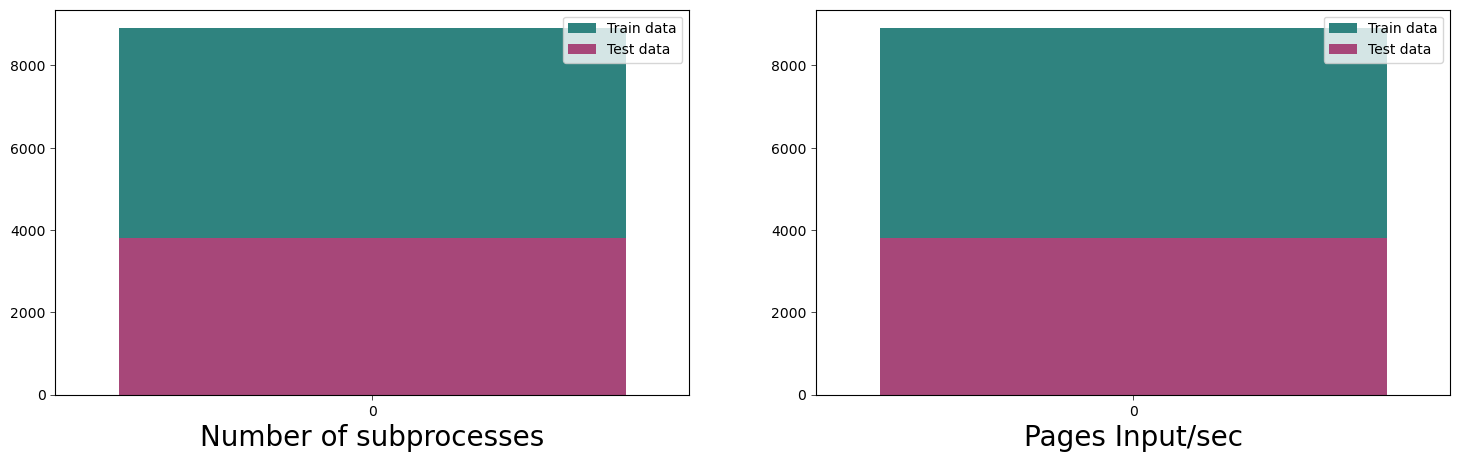

In [19]:
if len(cat_features) == 0 :
    print("No Categorical features")
else:
    ncols = 2
    nrows = 1

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5))
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[c]
            sns.countplot(train[col],ax = axes[c] ,palette = "viridis", label='Train data')
            sns.countplot(test[col],ax = axes[c] ,palette = "magma", label='Test data')
            axes[c].legend()
            axes[c].set_ylabel('')
            axes[c].set_xlabel(col, fontsize=20)
            axes[c].tick_params(labelsize=10, width=0.5)
            axes[c].xaxis.offsetText.set_fontsize(4)
            axes[c].yaxis.offsetText.set_fontsize(4)
    plt.show()
     

### Outlier Detection

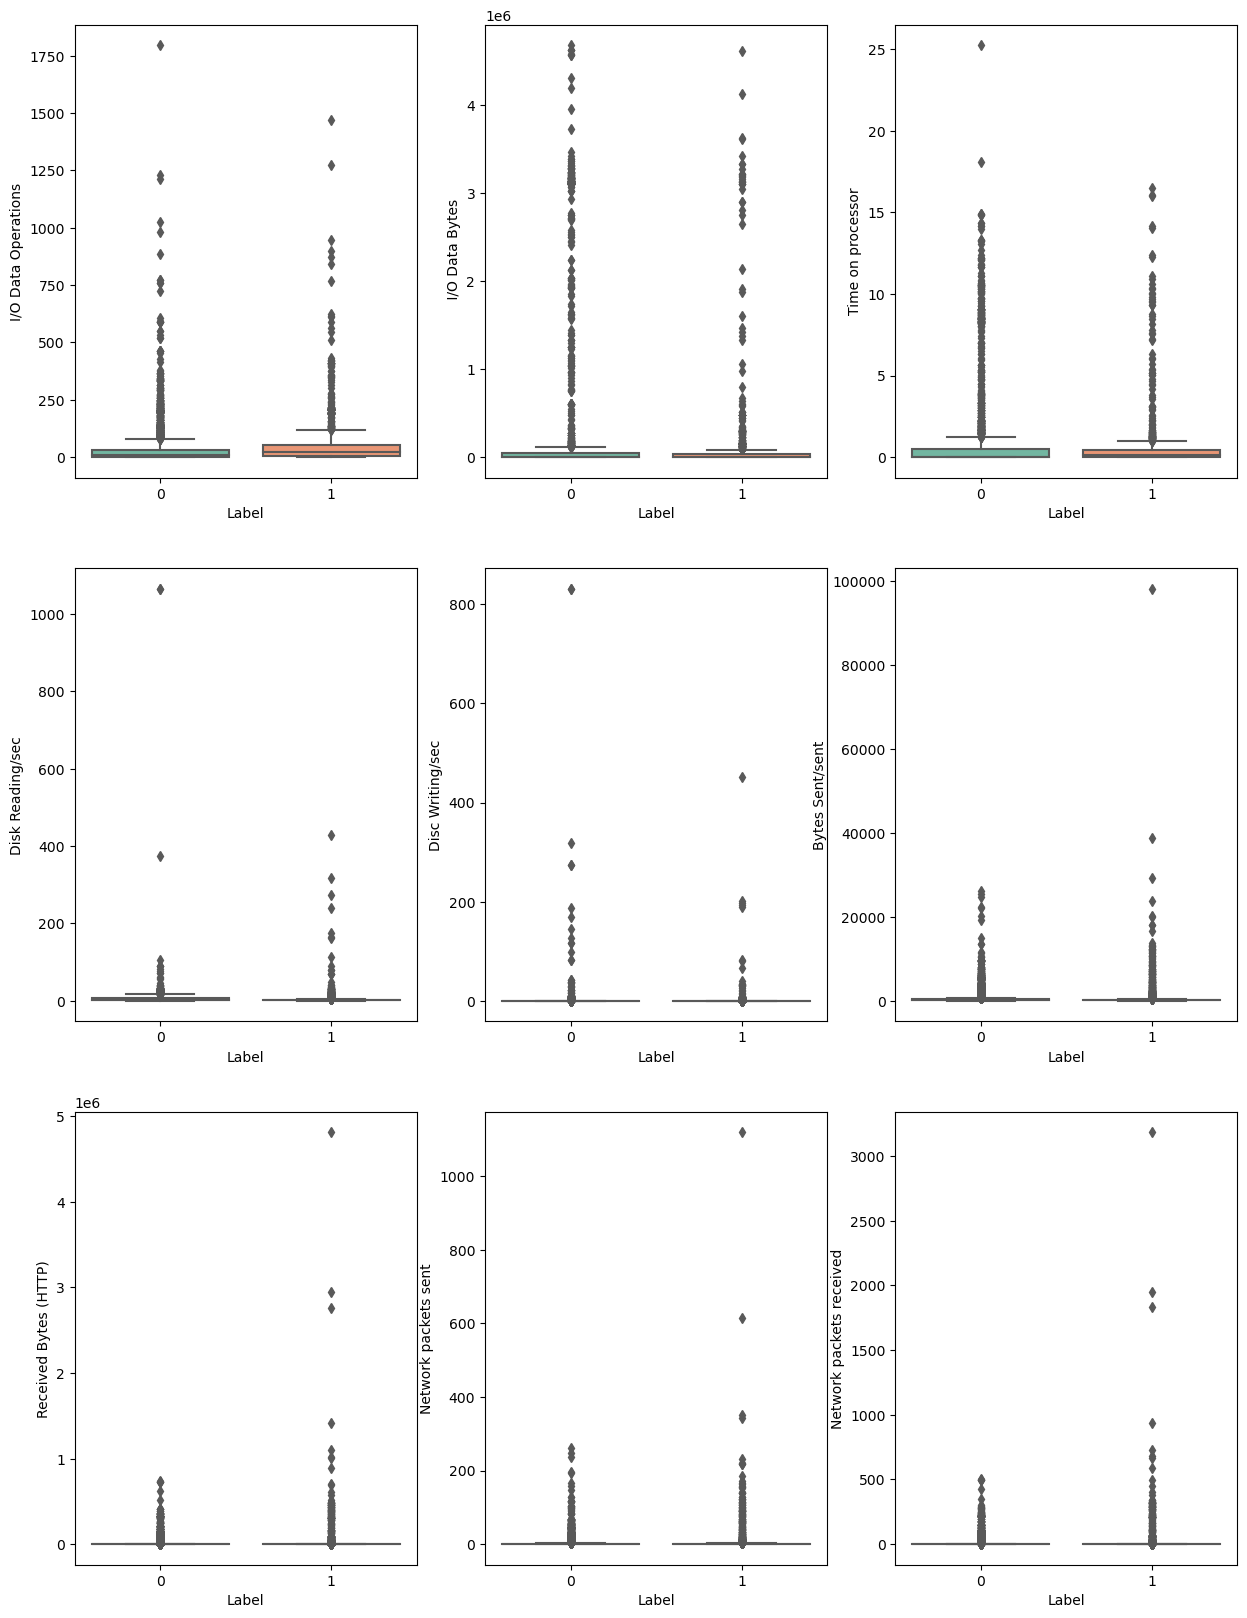

In [20]:
cotinuous_column_list = num_cols
fig, ax = plt.subplots(3,3, figsize=(15,20))
row, col = 3, 3
col_count = 0
for r in range(row):
    for c in range(col):
        sns.boxplot(data=train, x="Label", y=cotinuous_column_list[col_count], ax=ax[r,c], palette="Set2")
        
        col_count += 1
     

### Numerical Data Distribution
* We noticed that the data was higly skewed so we log transform it

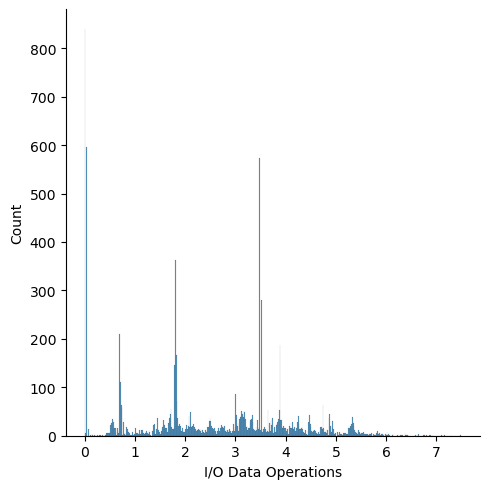

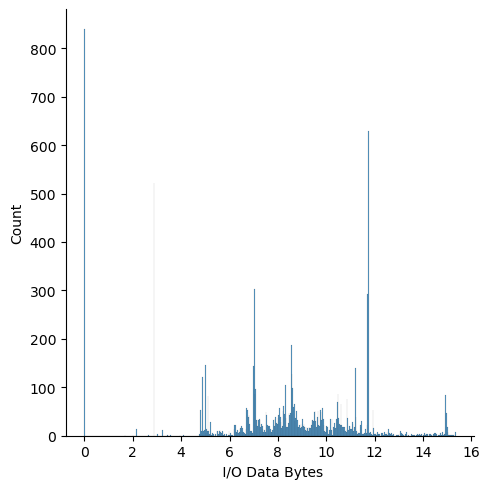

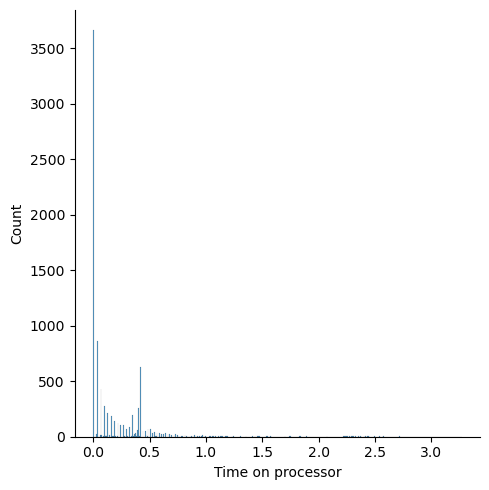

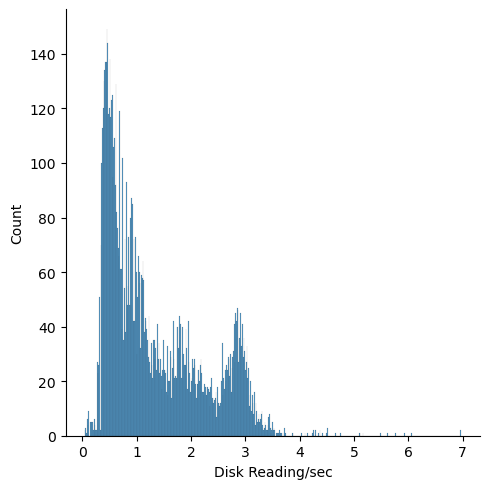

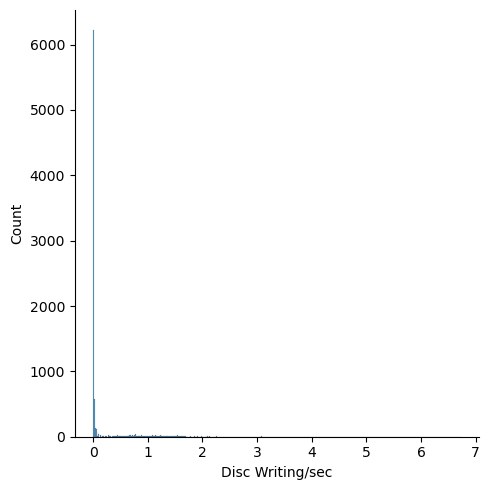

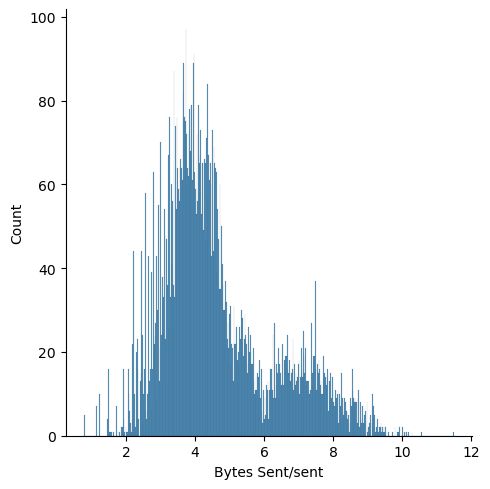

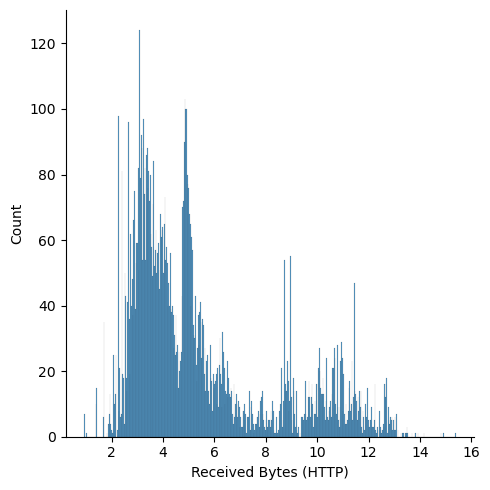

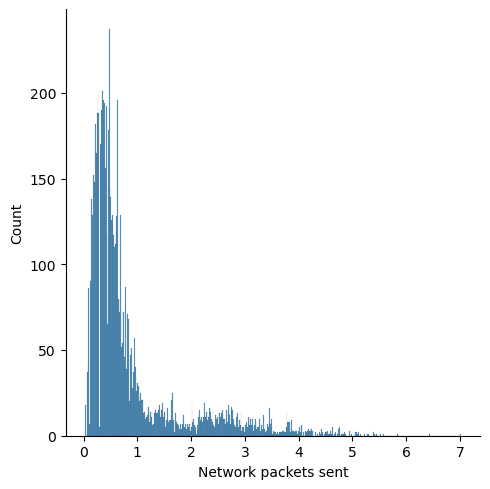

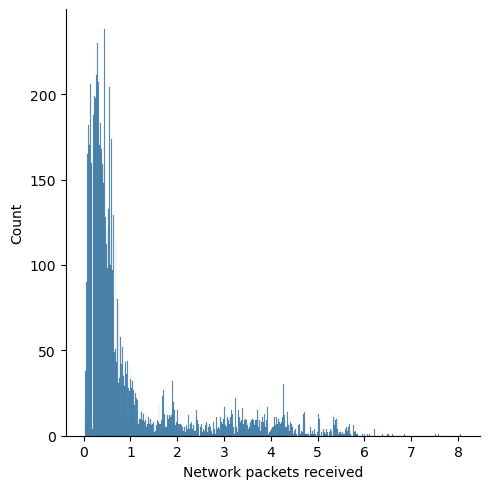

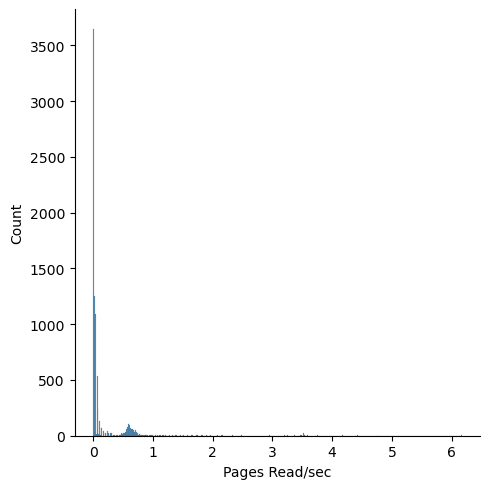

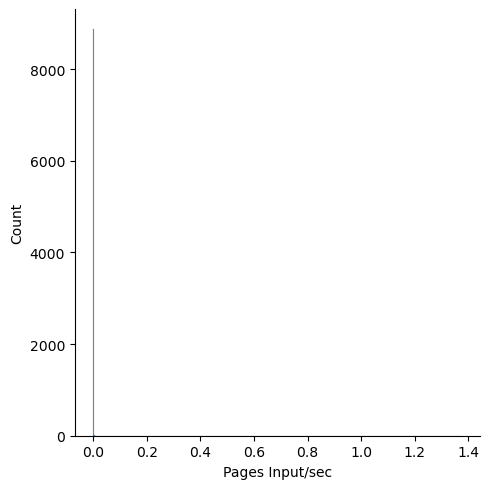

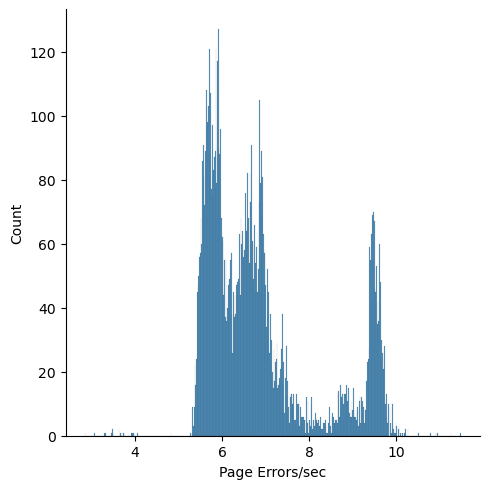

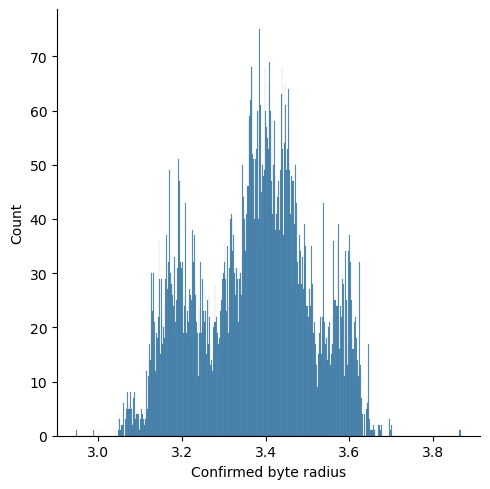

In [21]:
num_cols = [col for col in train.select_dtypes(['int','float']) if col not in ['Label','Number of subprocesses']]


for col in num_cols:
    sns.displot(np.log1p(train[col]), bins = 500)



### Feature Engineering

In [22]:
for df in [train, test]:
    #apply log transformation
    for col in num_cols:
        df[col] = np.log1p(df[col])
        
        
    #feature interactions
    df['reads_vs_writes'] = df['Disk Reading/sec'] / df['Disc Writing/sec']
    df['total_sent'] = df['Network packets sent'] + df['Bytes Sent/sent']
    df['total_received'] = df['Network packets received'] + df['Received Bytes (HTTP)']
    df['diff_sent_received'] = df['total_sent'] - df['total_received']
    df['IO_TOTAL'] = df['I/O Data Operations'] + df[' I/O Data Bytes']

### Modelling Preparation

In [23]:
main_cols = [col for col in train.columns if col not in ['ID','Label','Pages Input/sec']] #
X = train[main_cols]
y = train['Label']

X.shape, y.shape

((8908, 18), (8908,))

### Simple Train Test Split

In [24]:
model = catt.CatBoostClassifier(random_state = 42,)

import random
random.seed(123)

train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.18, stratify = y,random_state = 42)
model.fit(train_features, train_y,eval_set = [(train_features, train_y),(valid_features,valid_y)], early_stopping_rounds = 500, 
          verbose = 200)

Learning rate set to 0.051786
0:	learn: 0.6256586	test: 0.6257075	test1: 0.6255725	best: 0.6255725 (0)	total: 66.5ms	remaining: 1m 6s
200:	learn: 0.0883449	test: 0.0883694	test1: 0.1054577	best: 0.1054577 (200)	total: 1.26s	remaining: 5.02s
400:	learn: 0.0452609	test: 0.0452803	test1: 0.0761824	best: 0.0761824 (400)	total: 2.43s	remaining: 3.63s
600:	learn: 0.0279940	test: 0.0280096	test1: 0.0653266	best: 0.0653266 (600)	total: 3.67s	remaining: 2.43s
800:	learn: 0.0187661	test: 0.0187788	test1: 0.0596677	best: 0.0596600 (799)	total: 4.97s	remaining: 1.24s
999:	learn: 0.0132550	test: 0.0132655	test1: 0.0569703	best: 0.0568556 (988)	total: 6.13s	remaining: 0us

bestTest = 0.05685555627
bestIteration = 988

Shrink model to first 989 iterations.


In [27]:
y_predicted_proba=pd.Series(model.predict_proba(valid_features)[:,1])
print("The FI score is: ",f1_score(valid_y, model.predict(valid_features)))



The FI score is:  0.9631391200951249


* an F1 score of 0.9631 is actually good but vcan it get better? 
* We introduce tuning f1 score with thresholds

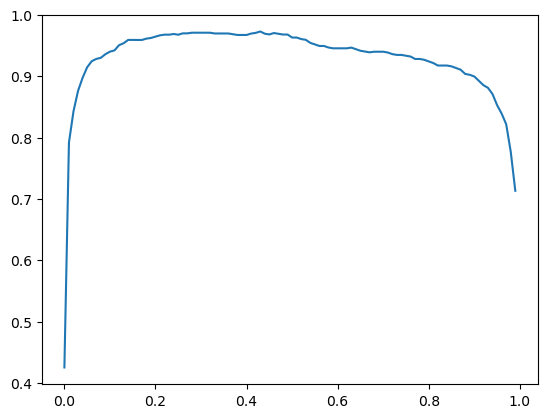

In [31]:
## Maximizing F1_Score
def tune_treshold(proba,threshold):
  if proba>threshold:
    return 1
  else:
    return 0

threshold_range=np.arange(0,1,0.01)
f1_scores=[]
for i in threshold_range:
  tuned_predictions=y_predicted_proba.apply(tune_treshold,args=(i,))
  f1_scores.append(f1_score(tuned_predictions,valid_y))

plt.plot(threshold_range,f1_scores)    
    
    


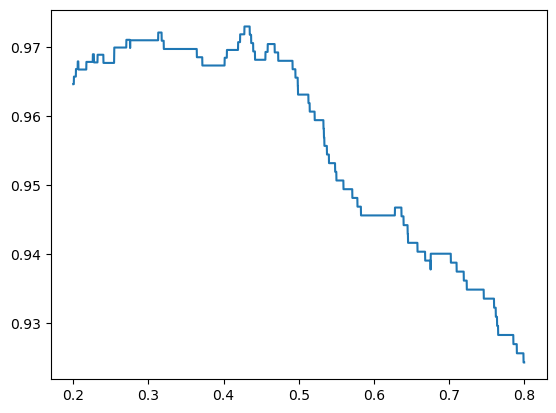

In [32]:
threshold_range=np.arange(0.2,0.8,0.0001)
f1_scores=[]
for i in threshold_range:
  tuned_predictions=y_predicted_proba.apply(tune_treshold,args=(i,))
  f1_scores.append(f1_score(tuned_predictions,valid_y))
    
plt.plot(threshold_range,f1_scores)        

In [33]:
best_threshold = 0.29

In [34]:
print(f"Your validation f1_score is {f1_score(y_predicted_proba.apply(tune_treshold,args=(best_threshold,)),valid_y)}")

Your validation f1_score is 0.9710312862108923


* Now our validation score increased to 0.9710

### How well does this model generalize: We use StratifiedKFold

### LIGHTGBM

In [35]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.6848093480934809, 1: 1.8527454242928452}

In [36]:
from sklearn.model_selection import StratifiedKFold
fold_pred=[]
oof_pred = []

params ={'learning_rate': 0.22994166022446474,
 'reg_lambda': 4.6641078076632683e-07,
 'reg_alpha': 1.3446320442365323e-06,
 'subsample': 0.5678465522885833,
 'colsample_bytree': 0.399651510718098,
 'max_depth': 8,
 'class_weight': {0: 0.6848093480934809, 1: 1.8527454242928452},         
 'objective':'binary'}


fold= StratifiedKFold(n_splits=5)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):     
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    model = lgb.LGBMClassifier(**params, random_state=42)

    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=50, verbose = False)#erly100

    preds= model.predict(X_test, num_iteration=model.best_iteration_)
    print("err: ",(f1_score(y_test,preds)))  
    oof_pred.append(f1_score(y_test,preds))
    p2 = model.predict_proba(test[X.columns], num_iteration=model.best_iteration_)[:, 1]
    fold_pred.append(p2)
    

print(np.mean(oof_pred))

err:  0.9509906152241919
err:  0.9622641509433961
err:  0.943157894736842
err:  0.9603340292275574
err:  0.95525494276795
0.9544003265799874


* We get an overall F1 score: 0.9544003265799874 with random params, we can obviously tune the params later

0.9625803560379517

### Feature Importances???

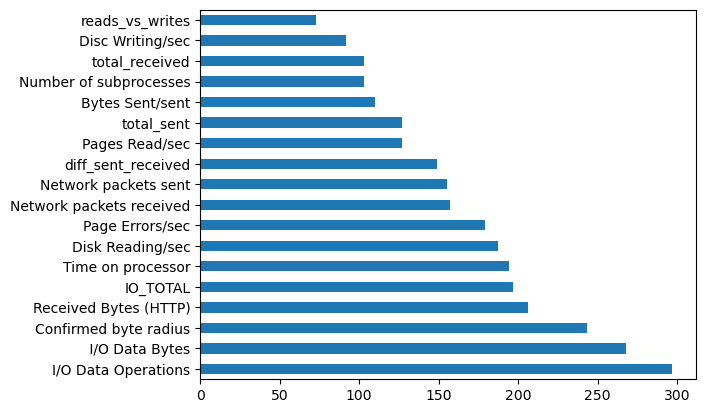

In [37]:
# plot model feature importance

import matplotlib.pyplot as plt
import seaborn as sns

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

* We can see how each feature is important to the model

### Next steps:
* Assess the predicted results, on the held out set which was not used in both training and validation